In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F

# PSNR 계산 함수
def calculate_psnr(img1, img2, max_val=1.0):
    mse = F.mse_loss(img1, img2, reduction='mean')
    if mse == 0:
        return float('inf')
    return 10 * torch.log10(max_val**2 / mse)

# SSIM 계산 함수
def calculate_ssim(img1, img2, max_val=1.0):
    C1 = (0.01 * max_val) ** 2
    C2 = (0.03 * max_val) ** 2

    mu1 = F.avg_pool2d(img1, kernel_size=3, stride=1, padding=1)
    mu2 = F.avg_pool2d(img2, kernel_size=3, stride=1, padding=1)

    sigma1_sq = F.avg_pool2d(img1 * img1, kernel_size=3, stride=1, padding=1) - mu1.pow(2)
    sigma2_sq = F.avg_pool2d(img2 * img2, kernel_size=3, stride=1, padding=1) - mu2.pow(2)
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=3, stride=1, padding=1) - mu1 * mu2

    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1.pow(2) + mu2.pow(2) + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

# 저해상도 이미지 생성 함수
def create_low_res_images(input_dir, output_dir, scale):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):
            img = Image.open(os.path.join(input_dir, filename))
            lr_img = img.resize((img.width // scale, img.height // scale), Image.BICUBIC)
            lr_img.save(os.path.join(output_dir, filename))

# 데이터셋 클래스
def get_image_paths(directory):
    return sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

class SRDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, transform=None, target_size=(256, 256)):
        self.hr_paths = get_image_paths(hr_dir)
        self.lr_paths = get_image_paths(lr_dir)
        self.transform = transform
        self.target_size = target_size

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        hr_img = Image.open(self.hr_paths[idx]).convert("RGB")
        lr_img = Image.open(self.lr_paths[idx]).convert("RGB")
        
        if self.target_size:
            hr_img = hr_img.resize(self.target_size, Image.BICUBIC)
            lr_img = lr_img.resize(self.target_size, Image.BICUBIC)

        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)

        return lr_img, hr_img

# 단순 SRCNN 모델
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# VDSR 모델 클래스
class VDSR(nn.Module):
    def __init__(self):
        super(VDSR, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.residual_layer = self.make_layer(64, 18)
        self.conv2 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def make_layer(self, channels, num_layers):
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Conv2d(channels, channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.conv1(x))
        out = self.residual_layer(out)
        out = self.conv2(out)
        out += residual  # Skip connection
        return out

# 학습 및 검증 루프 함수
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, save_path):
    best_valid_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_psnr = 0, 0

        for lr_imgs, hr_imgs in train_loader:
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
            preds = model(lr_imgs)
            loss = criterion(preds, hr_imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_psnr += calculate_psnr(preds, hr_imgs).item()

        train_loss /= len(train_loader)
        train_psnr /= len(train_loader)

        model.eval()
        valid_loss, valid_psnr, valid_ssim = 0, 0, 0

        with torch.no_grad():
            for lr_imgs, hr_imgs in valid_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                preds = model(lr_imgs)
                valid_loss += criterion(preds, hr_imgs).item()
                valid_psnr += calculate_psnr(preds, hr_imgs).item()
                valid_ssim += calculate_ssim(preds, hr_imgs).item()

        valid_loss /= len(valid_loader)
        valid_psnr /= len(valid_loader)
        valid_ssim /= len(valid_loader)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train PSNR: {train_psnr:.4f} | "
              f"Valid Loss: {valid_loss:.4f} | Valid PSNR: {valid_psnr:.4f} | Valid SSIM: {valid_ssim:.4f}")

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)
            print("Best model saved!")

# 설정 및 초기화
def main():
    train_hr_dir = "/home/jangho/CPN/train"
    train_lr_dir = "/home/jangho/CPN/train_lr"
    valid_hr_dir = "/home/jangho/CPN/test"
    valid_lr_dir = "/home/jangho/CPN/test_lr"

    # 저해상도 데이터셋 생성
    create_low_res_images(train_hr_dir, train_lr_dir, scale=4)
    create_low_res_images(valid_hr_dir, valid_lr_dir, scale=4)

    transform = transforms.ToTensor()
    train_dataset = SRDataset(train_hr_dir, train_lr_dir, transform, target_size=(256, 256))
    valid_dataset = SRDataset(valid_hr_dir, valid_lr_dir, transform, target_size=(256, 256))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 모델 및 학습 설정
    models = {
        "SRCNN": SRCNN().to(device),
        "VDSR": VDSR().to(device)
    }
    criterion = nn.MSELoss()

    for model_name, model in models.items():
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        save_path = f"/home/jangho/CPN/{model_name}_best_model.pth"

        print(f"Training {model_name}...")
        train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=25, save_path=save_path)

    # 테스트 루프
    test_dataset = SRDataset(valid_hr_dir, valid_lr_dir, transform, target_size=(256, 256))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    for model_name, model in models.items():
        model.load_state_dict(torch.load(f"/home/jangho/CPN/{model_name}_best_model.pth"))
        model.eval()

        test_psnr, test_ssim = 0, 0
        with torch.no_grad():
            for lr_imgs, hr_imgs in test_loader:
                lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
                preds = model(lr_imgs)
                test_psnr += calculate_psnr(preds, hr_imgs).item()
                test_ssim += calculate_ssim(preds, hr_imgs).item()

        test_psnr /= len(test_loader)
        test_ssim /= len(test_loader)

        print(f"{model_name} - Test PSNR: {test_psnr:.4f}, Test SSIM: {test_ssim:.4f}")

if __name__ == "__main__":
    main()  


Training SRCNN...
Epoch 1/25 | Train Loss: 0.0111 | Train PSNR: 20.6373 | Valid Loss: 0.0075 | Valid PSNR: 21.3747 | Valid SSIM: 0.7274
Best model saved!


KeyboardInterrupt: 

/tmp/ipykernel_1648866/2390175849.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/home/jangho/CPN/{model_name}_best_model.pth"))


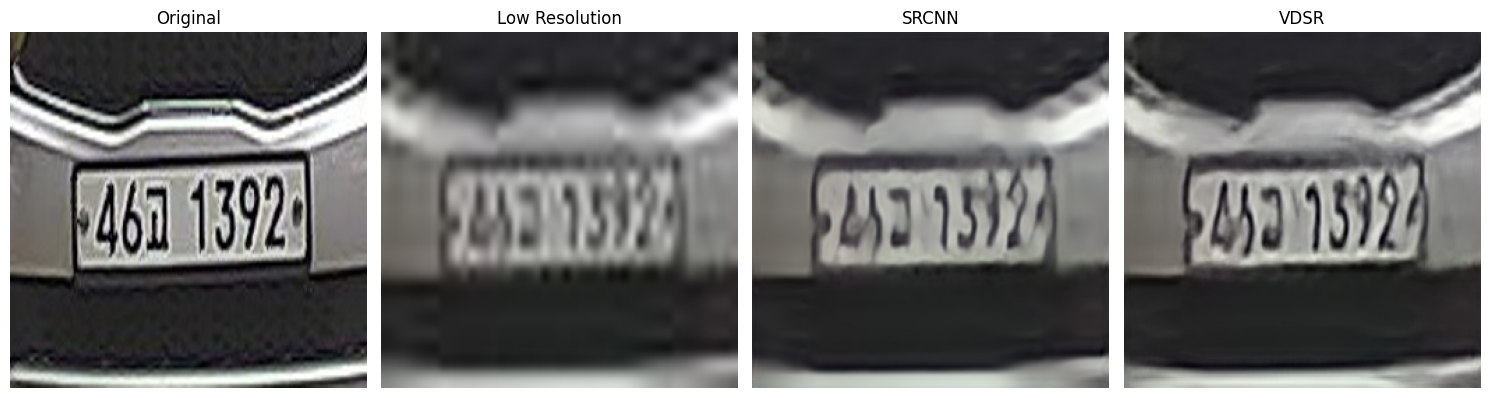

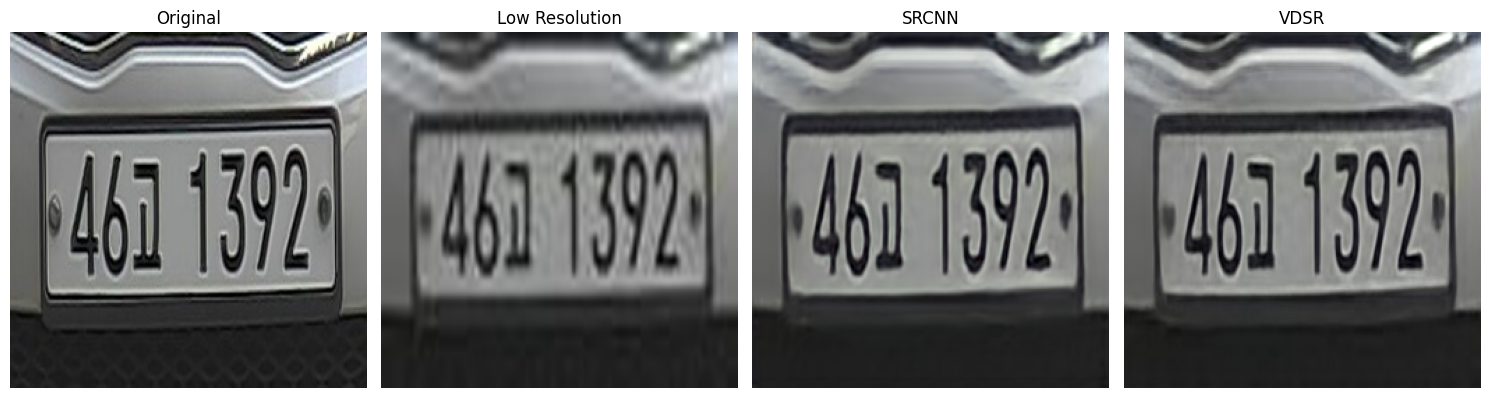

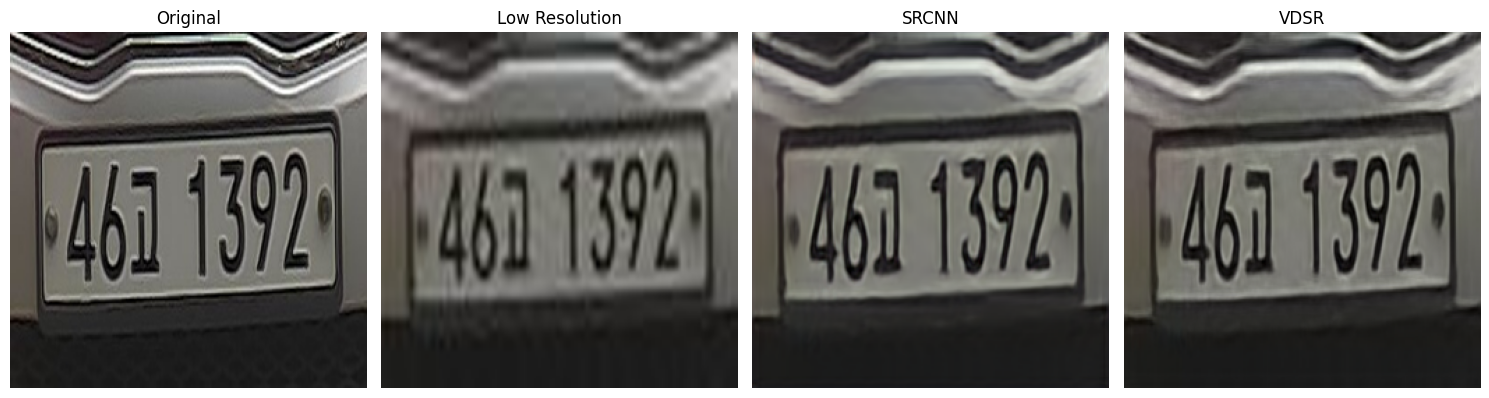

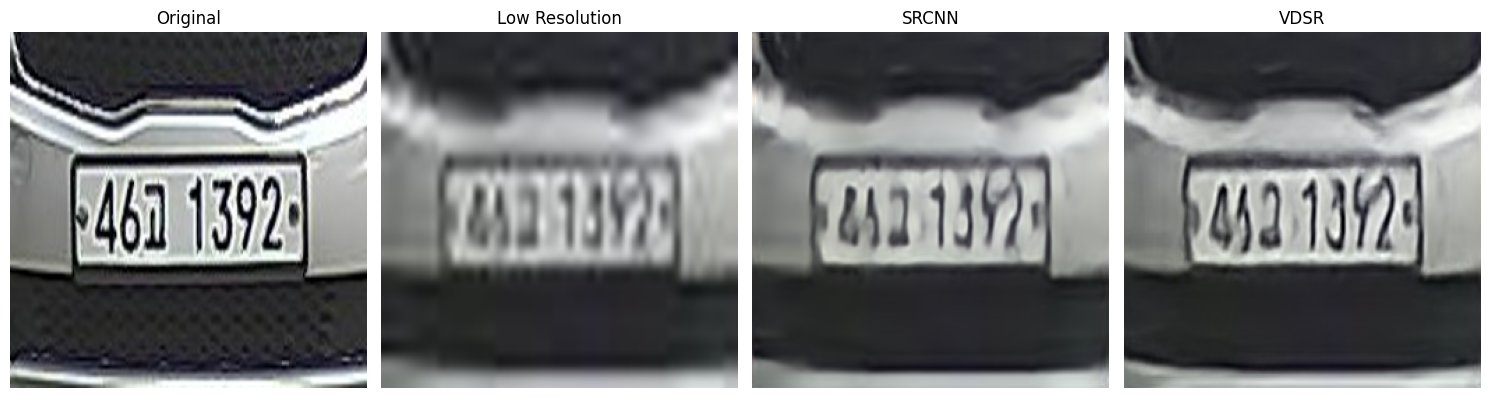

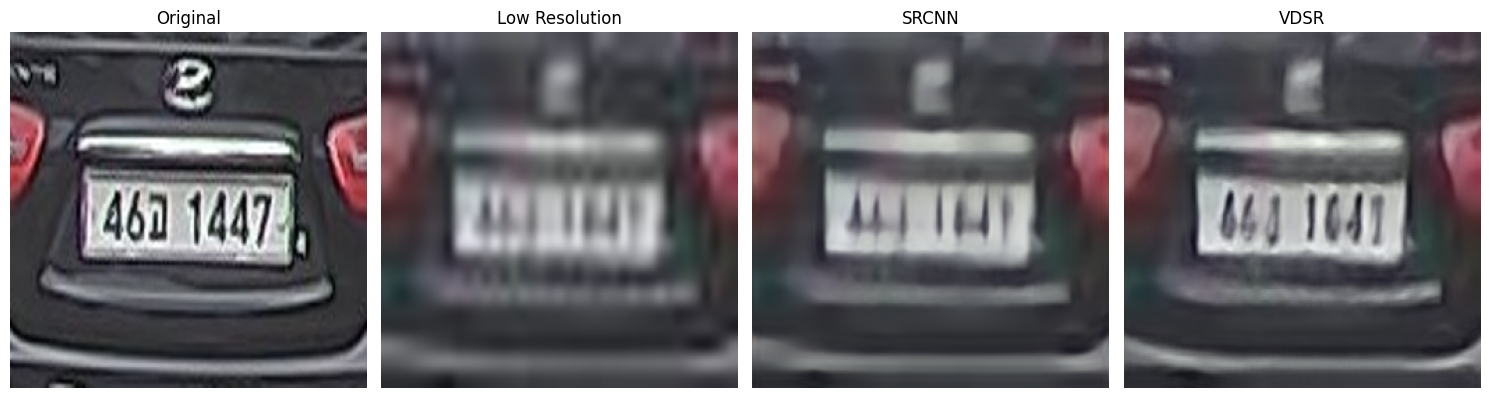

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import DataLoader

# 시각화를 위한 함수
def visualize_sr_results(models, test_loader, device, output_dir="./results"):
    os.makedirs(output_dir, exist_ok=True)
    to_pil = ToPILImage()

    # 테스트 데이터에서 첫 번째 배치만 사용
    lr_imgs, hr_imgs = next(iter(test_loader))
    lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

    for i in range(len(lr_imgs)):
        fig, axes = plt.subplots(1, len(models) + 2, figsize=(15, 5))

        # 원본 HR 이미지
        original_img = hr_imgs[i]
        axes[0].imshow(to_pil(original_img))
        axes[0].set_title("Original")
        axes[0].axis("off")

        # 저해상도 LR 이미지
        lr_img = lr_imgs[i]
        axes[1].imshow(to_pil(lr_img))
        axes[1].set_title("Low Resolution")
        axes[1].axis("off")

        # 각 모델 결과 시각화
        for j, (model_name, model) in enumerate(models.items()):
            model.eval()
            with torch.no_grad():
                sr_img = model(lr_img.unsqueeze(0)).squeeze(0)  # 모델에 입력 및 결과 얻기
            sr_img = torch.clamp(sr_img, 0, 1)  # 값 제한 [0, 1]

            axes[j + 2].imshow(to_pil(sr_img))
            axes[j + 2].set_title(model_name)
            axes[j + 2].axis("off")

        plt.tight_layout()
        output_path = os.path.join(output_dir, f"result_{i}.png")
        plt.savefig(output_path)
        plt.show()

# 테스트 루프 및 시각화 실행 코드
def main():
    test_hr_dir = "/home/jangho/CPN/test"
    test_lr_dir = "/home/jangho/CPN/test_lr"

    # Transform 설정
    transform = ToTensor()

    # 테스트 데이터셋 및 로더 준비
    test_dataset = SRDataset(test_hr_dir, test_lr_dir, transform, target_size=(256, 256))
    test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 모델 로드
    models = {
        "SRCNN": SRCNN().to(device),
        "VDSR": VDSR().to(device),
    
    }

    for model_name, model in models.items():
        model.load_state_dict(torch.load(f"/home/jangho/CPN/{model_name}_best_model.pth"))

    # 결과 시각화
    visualize_sr_results(models, test_loader, device)

if __name__ == "__main__":
    main()
